# Denoising

In this simple notebook, we look at a denoising problem and how the linearized bregman iterations provide a simple and efficient solution.

# Packages setup

In [1]:
# ] registry add https://github.com/slimgroup/SLIMregistryJL.git
# ] add LinearAlgebra, JOLI, TestImages, ImageView

In [2]:
using SlimOptim, LinearAlgebra, JOLI, TestImages, PyPlot
import TestImages: Gray

┌ Info: Precompiling SlimOptim [e4c7bc62-5b23-4522-a1b9-71c2be45f1df]
└ @ Base loading.jl:1278
┌ Info: Precompiling JOLI [bb331ad6-a1cf-11e9-23da-9bcb53c69f6f]
└ @ Base loading.jl:1278
┌ Info: Precompiling TestImages [5e47fb64-e119-507b-a336-dd2b206d9990]
└ @ Base loading.jl:1278


# Use a standard reference image

In [30]:
n = 256
k = 4
n1, n2 = k*256, 256
img = Float32.(Gray.(testimage("lighthouse.png")[1:2:end, 129:2:end-128]));

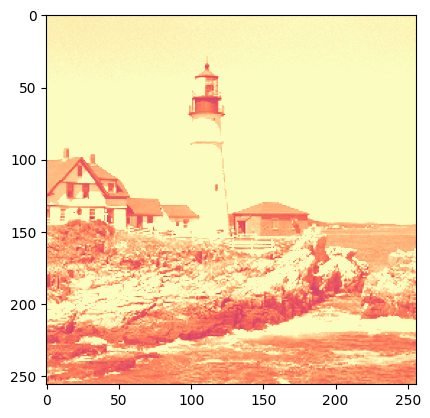

In [31]:
imshow(img, cmap="magma", vmin=-.5, vmax=.5);

# Measurment operator

In [32]:
A = vcat([joRomberg(n, n; DDT=Float32, RDT=Float32) for i=1:k]...);

# Setup transform domain operator

In [33]:
# Sparse in wavelet domain
W = joDWT(n, n; DDT=Float32, RDT=Float32);
# Or with curvelet ifi nstalled
# W = joCurvelet2D(128, 128; DDT=Float32, RDT=Float32);

# Measurements

In [40]:
# Make noisy data
b = A*vec(img);
b += .01f0*randn(Float32, size(b));

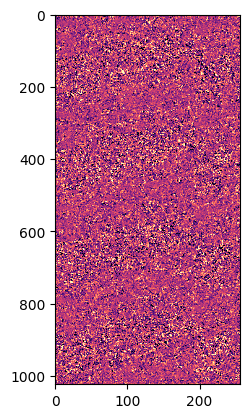

PyObject <matplotlib.image.AxesImage object at 0x1593e5a00>

In [41]:
imshow(reshape(b, n1, n2), cmap="magma", vmin=-.5, vmax=.5, aspect=.5)

# Linearized bregman

We solve the following l1-l2 optimization problem:

$$
\begin{align}
\min_x & \ \ \lambda || W x||_1 + \frac{1}{2} ||W x ||_2^2 \\
          & \text{s.t. } Ax = b
\end{align}
$$

where $W$ is the sparsity promoting transform, $x$ is the unknown image and $A$ is a tall measuremment operator.

In [42]:
# setup bregman
opt = bregman_options(maxIter=200, verbose=2, quantile=.5, antichatter=true, spg=true)

SlimOptim.BregmanParams(2, 1.0e-8, 200, false, true, 0.5, 0.5, true)

In [43]:
sol = bregman(A, W, zeros(Float32, n*n), b, opt);

Running linearized bregman...
Progress tolerance: 1.00e-08
Maximum number of iterations: 200
Anti-chatter correction: 1
 Iteration     Step Length Bregman residual ||A*x - b||_2^2     λ
         1     6.25195e-02     4.96818e+02     3.15831e+04     3.56682e-03 
         2     2.50000e-01     7.91931e+03     1.78044e+04     3.56682e-03 
         3     2.50000e-01     7.91988e+03     1.00422e+01     3.56682e-03 
         4     2.50000e-01     7.91993e+03     9.85426e+00     3.56682e-03 
         5     2.50000e-01     7.91995e+03     9.84385e+00     3.56682e-03 
         6     2.50000e-01     7.91996e+03     9.84151e+00     3.56682e-03 
         7     2.50000e-01     7.91997e+03     9.84075e+00     3.56682e-03 
         8     2.50000e-01     7.91997e+03     9.84041e+00     3.56682e-03 
         9     2.49997e-01     7.91997e+03     9.84023e+00     3.56682e-03 
        10     2.50001e-01     7.91997e+03     9.84013e+00     3.56682e-03 
        11     2.50003e-01     7.91997e+03     9.84008

# Plot result and convergence

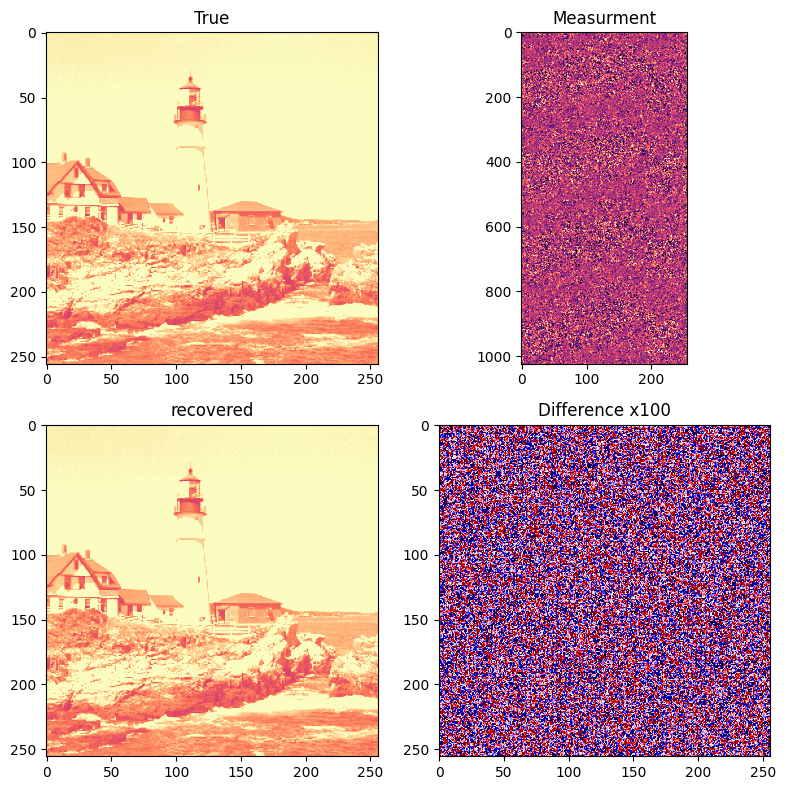

In [44]:
figure(figsize=(8,8));
subplot(221)
imshow(img, cmap="magma", vmin=-.5, vmax=.5)
title("True")
subplot(222)
imshow(reshape(b, n1, n2), cmap="magma", vmin=-.5, vmax=.5, aspect=.5)
title("Measurment")
subplot(223)
imshow(reshape(sol.x, n, n), cmap="magma", vmin=-.5, vmax=.5)
title("recovered")
subplot(224)
imshow(img - reshape(sol.x, n, n), cmap="seismic", vmin=-.5e-2, vmax=.5e-2)
title("Difference x100")
tight_layout()

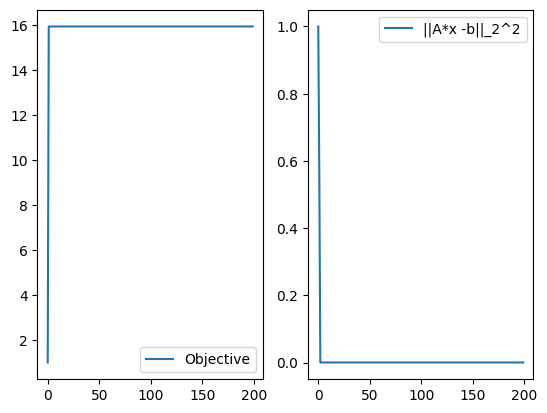

PyObject <matplotlib.legend.Legend object at 0x158deb3a0>

In [45]:
figure()
subplot(121)
plot(sol.ϕ_trace/sol.ϕ_trace[1], label="Objective")
legend()
subplot(122)
plot(sol.r_trace/sol.r_trace[1], label="||A*x -b||_2^2")
legend()